In [1]:
import pandas as pd
import pycaret as pc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter 
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data 
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive


In [2]:
!pwd

/Users/0ill/Documents/mlops_works/notebooks


In [3]:
# Set the number of people and days
n_people = 2000
n_days = 210  # 3 months

# Create a date range
dates = pd.date_range('2024-01-01', periods=n_days)

# Generate random amounts
np.random.seed(0)
amounts = np.random.randint(1, 1000, size=(n_people*n_days))

# Create a dataframe with ID, Date, and Amount
start_data = pd.DataFrame({
    'ID': np.repeat(range(1, n_people+1), n_days),
    'Date': np.tile(dates, n_people),
    'Amount': amounts
})

# Randomly remove some transactions to simulate irregular buying behavior
start_data = start_data.sample(frac=0.90, random_state=0)
start_data = start_data.sample(frac=0.5, random_state=3000)
start_data = start_data.sample(frac=0.80, random_state=57)
start_data = start_data.sample(frac=0.6, random_state=534)

# Save the dataset to a CSV file
start_data.to_csv('../data/transactional_data.csv', index=False)
print(start_data.head(),start_data['Date'].max())

          ID       Date  Amount
94619    451 2024-04-29     150
120928   576 2024-06-27     702
186953   891 2024-02-23     619
139084   663 2024-03-05     654
229891  1095 2024-05-31     898 2024-07-28 00:00:00


In [4]:
data = summary_data_from_transaction_data(start_data, 'ID', 'Date','Amount', observation_period_end='2024-03-30',)

In [5]:
data

,frequency,recency,T,monetary_value
ID,,,,
1,20.0,81.0,85.0,525.850000
2,20.0,84.0,84.0,454.600000
3,21.0,83.0,89.0,446.904762
4,21.0,87.0,87.0,430.238095
5,31.0,86.0,89.0,471.419355
...,...,...,...,...
1996,21.0,88.0,88.0,626.761905
1997,20.0,87.0,87.0,509.700000
1998,15.0,76.0,83.0,566.733333


In [6]:
# Summary statistics
print(data.describe())


         frequency      recency            T  monetary_value
count  2000.000000  2000.000000  2000.000000     2000.000000
mean     18.451000    81.900500    85.512500      498.564712
std       3.821505     5.812787     3.987455       67.995476
min       6.000000    46.000000    58.000000      258.562500
25%      16.000000    79.000000    84.000000      454.111364
50%      18.000000    83.000000    87.000000      499.717262
75%      21.000000    86.000000    88.000000      542.644097
max      34.000000    89.000000    89.000000      721.090909


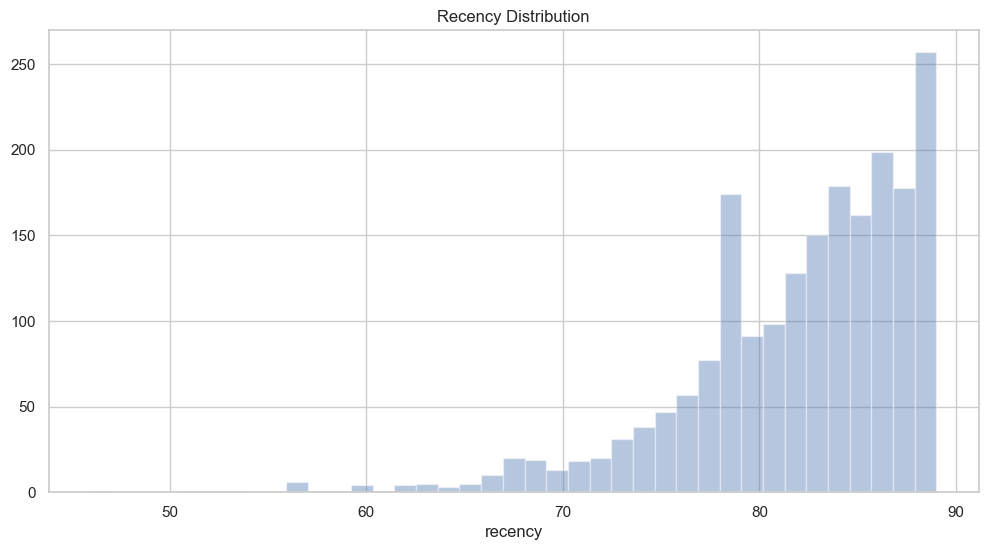

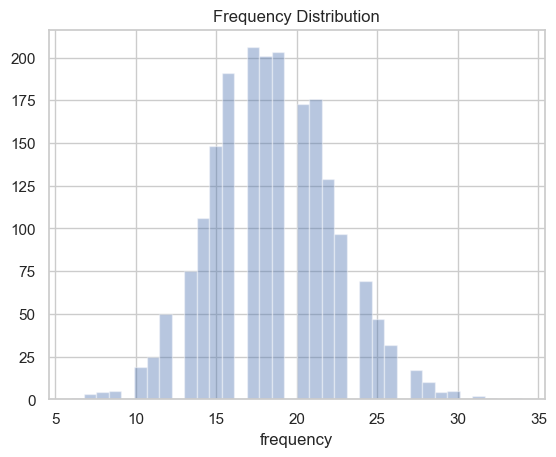

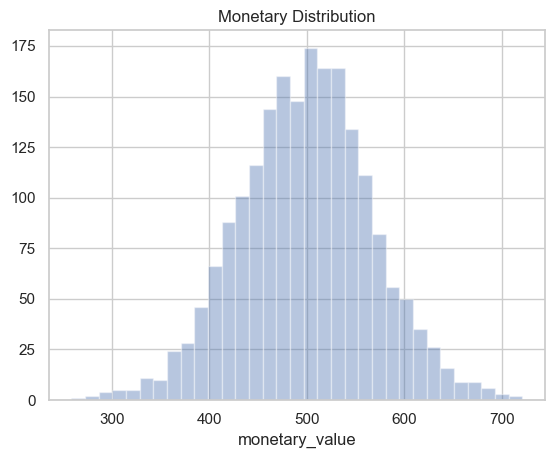

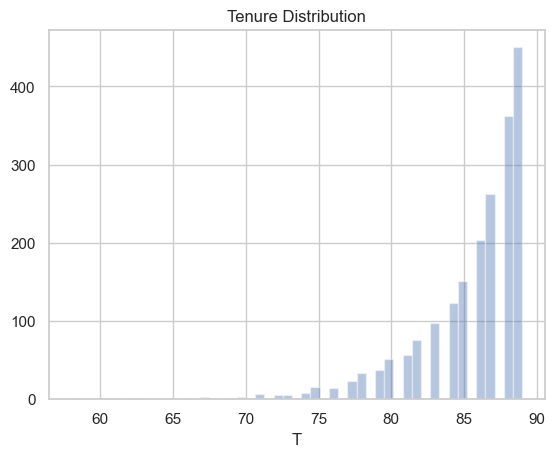

In [7]:
# Distribution plots
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

sns.distplot(data['recency'], kde=False)
plt.title('Recency Distribution')
plt.show()

sns.distplot(data['frequency'], kde=False)
plt.title('Frequency Distribution')
plt.show()

sns.distplot(data['monetary_value'], kde=False)
plt.title('Monetary Distribution')
plt.show()

sns.distplot(data['T'], kde=False)
plt.title('Tenure Distribution')
plt.show()


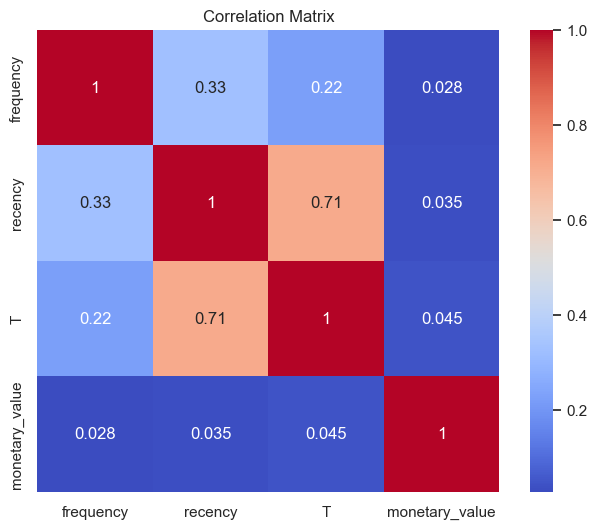

In [8]:
# Correlation heatmap
corr = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


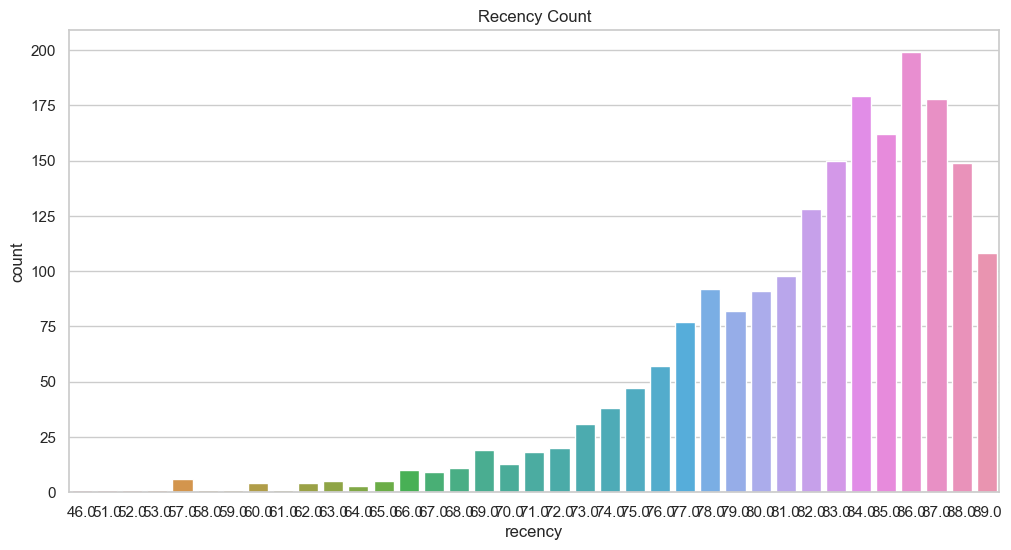

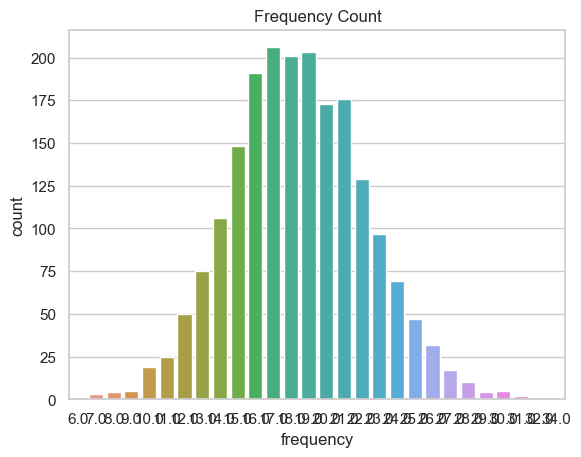

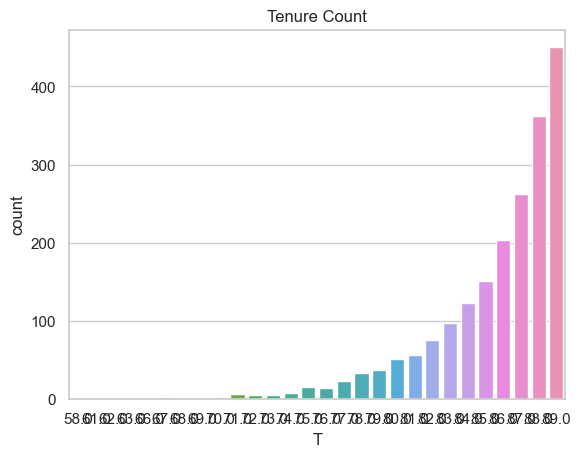

In [9]:
# Count plots
plt.figure(figsize=(12, 6))

sns.countplot(x=data['recency'])
plt.title('Recency Count')
plt.show()

sns.countplot(x=data['frequency'])
plt.title('Frequency Count')
plt.show()

sns.countplot(x=data['T'])
plt.title('Tenure Count')
plt.show()

In [10]:
data_f = data#[(data['Frequency'] > 0) & (data['Recency'] <= data['Tenure'])]

In [11]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive

In [12]:
bgf = BetaGeoFitter(penalizer_coef=3.001)
bgf.fit(data_f['frequency'], data_f['recency'], data_f['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2000 subjects, a: 0.00, alpha: 1.53, b: 0.00, r: 0.33>


<AxesSubplot: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

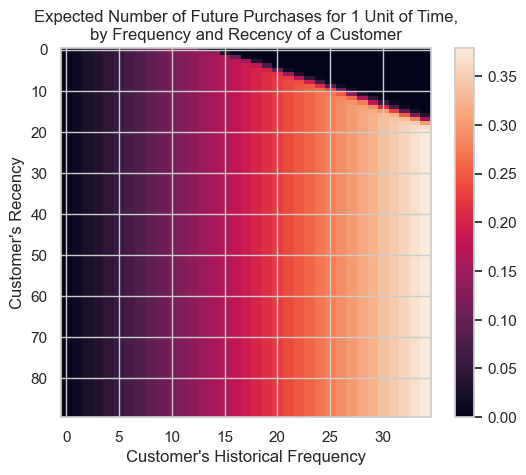

In [13]:
plot_frequency_recency_matrix(bgf)

<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

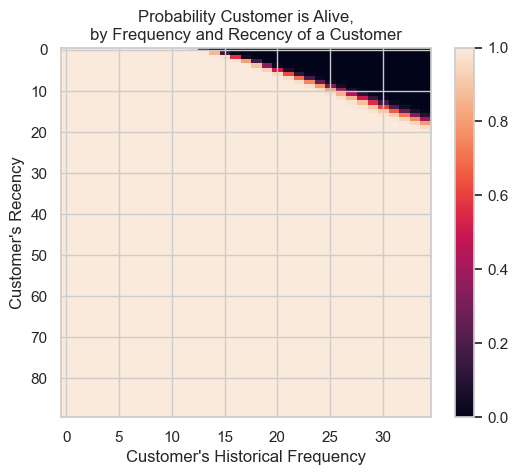

In [14]:
plot_probability_alive_matrix(bgf)

In [15]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data_f['frequency'], data_f['recency'], data_f['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
ID,,,,,
1881,31.0,89.0,89.0,528.806452,0.346096
5,31.0,86.0,89.0,471.419355,0.346096
859,30.0,79.0,83.0,560.200000,0.358832
1315,32.0,86.0,88.0,484.531250,0.361131
687,34.0,85.0,89.0,533.970588,0.379235


<AxesSubplot: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

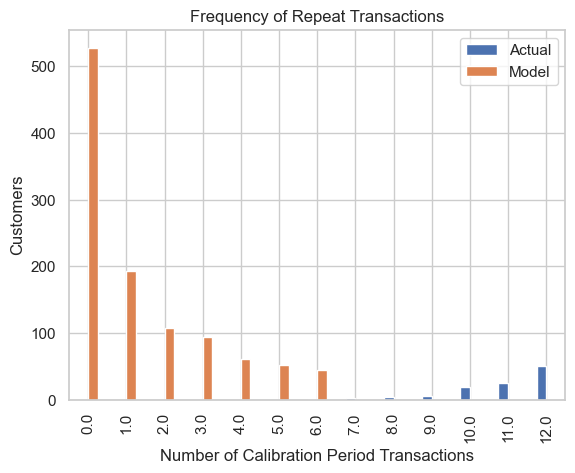

In [16]:
plot_period_transactions(bgf)

In [17]:
data_cal_holdout = calibration_and_holdout_data(start_data, 'ID', 'Date',
                                        calibration_period_end='2024-04-01',
                                        observation_period_end='2024-05-30' )
print(data_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
ID                                                                        
1            20.0         81.0   87.0                 13              59.0
2            21.0         86.0   86.0                 18              59.0
3            21.0         83.0   91.0                 11              59.0
4            22.0         88.0   89.0                 11              59.0
5            31.0         86.0   91.0                 12              59.0


In [18]:
bgf.fit(data_cal_holdout['frequency_cal'], data_cal_holdout['recency_cal'], data_cal_holdout['T_cal'])
bgf.save_model('../models/bgf_small_size.pkl', save_data=False, save_generate_data_method=False)

<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

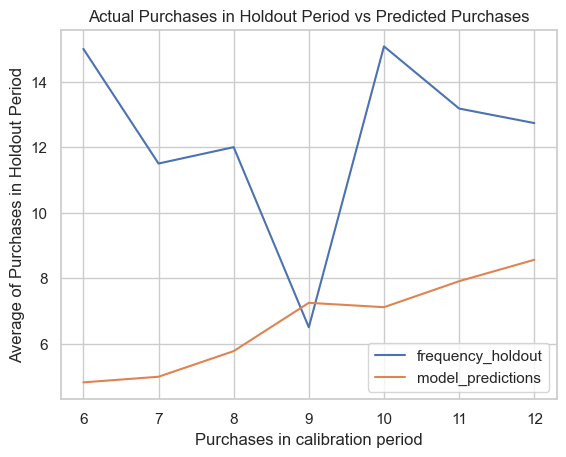

In [19]:
plot_calibration_purchases_vs_holdout_purchases(bgf, data_cal_holdout)

In [20]:
t = 10 #predict purchases in 10 periods
individual = data.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])


1.8874125398148978

In [1]:
id = 80
days_since_birth = 10
sp_trans = start_data.loc[start_data['ID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Date')

NameError: name 'start_data' is not defined

In [22]:
data_returning = data[data.frequency > 0]


In [23]:
data_returning[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.028208
frequency,0.028208,1.000000


In [24]:
from lifetimes import GammaGammaFitter


In [25]:
ggf = GammaGammaFitter(penalizer_coef = 10.)
ggf.fit(data_returning['frequency'],
        data_returning['monetary_value'])
print(ggf)
ggf.save_model('../models/ggf_small_size.pkl', save_data=False, save_generate_data_method=False)

<lifetimes.GammaGammaFitter: fitted with 2000 subjects, p: 0.07, q: 0.08, v: 0.06>


In [26]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

ID
1     1403.113106
2     1212.999538
3     1104.707218
4     1063.509033
5      790.140649
6     1275.385416
7    -5272.293800
8     1121.892747
9     1614.968840
10    1461.747453
dtype: float64


In [27]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).mean(),
    data[data['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 1778.5138736808155, Average profit: 498.5647120939049


In [28]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(data['frequency'], data['recency'], data['T'])


<lifetimes.BetaGeoFitter: fitted with 2000 subjects, a: 0.00, alpha: 1.53, b: 0.00, r: 0.33>

In [34]:
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.023 # monthly discount rate ~ 12.7% annually
).head(10))

ID
1     111320.410076
2      97362.349011
3      87893.149560
4      86526.908087
5      92335.914384
6     102606.121763
7    -235858.532209
8      92319.817168
9     116443.858505
10     99944.176854
Name: clv, dtype: float64


In [35]:
from pydantic import BaseModel